## K-Fold

In [1]:
import numpy as np
import pandas as pd



In [2]:
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, -1]

In [3]:
X = X.values
y = y.values

In [4]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])

labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([("Country", OneHotEncoder(),[1])], remainder="passthrough") # The last arg ([0]) is the list of columns you want to transform in this step
X = ct.fit_transform(X)
X = X[:, 1:]

In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [7]:
# Importing the Keras libraries and packages
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

# Evaluating the ANN
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

TensorFlow version: 2.4.0


In [8]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 10)
# n_jobs = -1 can cause errors if using tensorflow gpu for multiprocessing
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs=1)
mean = accuracies.mean()
variance = accuracies.std()


Epoch 1/10
720/720 [==============================] - 1s 898us/step - loss: 0.5526 - accuracy: 0.8085
Epoch 2/10
720/720 [==============================] - 1s 894us/step - loss: 0.4163 - accuracy: 0.8075
Epoch 3/10
720/720 [==============================] - 1s 871us/step - loss: 0.4228 - accuracy: 0.7993
Epoch 4/10
720/720 [==============================] - 1s 889us/step - loss: 0.4258 - accuracy: 0.8191
Epoch 5/10
720/720 [==============================] - 1s 944us/step - loss: 0.4270 - accuracy: 0.8247
Epoch 6/10
720/720 [==============================] - 1s 868us/step - loss: 0.4088 - accuracy: 0.8338
Epoch 7/10
720/720 [==============================] - 1s 885us/step - loss: 0.4128 - accuracy: 0.8358
Epoch 8/10
720/720 [==============================] - 1s 873us/step - loss: 0.4048 - accuracy: 0.8369
Epoch 9/10
720/720 [==============================] - 1s 882us/step - loss: 0.4049 - accuracy: 0.8335
Epoch 10/10
80/80 [==============================] - 0s 674us/step - loss: 0.4187 

720/720 [==============================] - 1s 866us/step - loss: 0.3825 - accuracy: 0.8361
Epoch 6/10
720/720 [==============================] - 1s 885us/step - loss: 0.3763 - accuracy: 0.8367
Epoch 7/10
720/720 [==============================] - 1s 856us/step - loss: 0.3716 - accuracy: 0.8370
Epoch 8/10
720/720 [==============================] - 1s 867us/step - loss: 0.3694 - accuracy: 0.8415
Epoch 9/10
720/720 [==============================] - 1s 863us/step - loss: 0.3658 - accuracy: 0.8523
Epoch 10/10
80/80 [==============================] - 0s 868us/step - loss: 0.3981 - accuracy: 0.8275
Epoch 1/10
720/720 [==============================] - 1s 1ms/step - loss: 0.5594 - accuracy: 0.7986
Epoch 2/10
720/720 [==============================] - 1s 879us/step - loss: 0.4284 - accuracy: 0.7980
Epoch 3/10
720/720 [==============================] - 1s 883us/step - loss: 0.4284 - accuracy: 0.7940
Epoch 4/10
720/720 [==============================] - 1s 938us/step - loss: 0.4184 - accuracy: 0

In [9]:
print(mean)
print(variance)

0.8382500052452088
0.011183129954213437


## GridSearch

In [11]:
# Tuning the ANN
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import ModelCheckpoint



In [12]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

parameters = {'batch_size': [10],
              'epochs': [10],
              'optimizer': ['adam', 'rmsprop']}
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10, 
                           n_jobs=1)

grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/10
720/720 [==============================] - 1s 955us/step - loss: 0.5746 - accuracy: 0.7899
Epoch 2/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4376 - accuracy: 0.8035
Epoch 3/10
720/720 [==============================] - 1s 958us/step - loss: 0.4411 - accuracy: 0.7883
Epoch 4/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4331 - accuracy: 0.7965
Epoch 5/10
720/720 [==============================] - 1s 954us/step - loss: 0.4391 - accuracy: 0.7915
Epoch 6/10
720/720 [==============================] - 1s 944us/step - loss: 0.4277 - accuracy: 0.7920
Epoch 7/10
720/720 [==============================] - 1s 964us/step - loss: 0.4263 - accuracy: 0.8007
Epoch 8/10
720/720 [==============================] - 1s 952us/step - loss: 0.4273 - accuracy: 0.8264
Epoch 9/10
720/720 [==============================] - 1s 943us/step - loss: 0.4396 - accuracy: 0.8206
Epoch 10/10
720/720 [==============================] - 1s 960us/step - loss: 0.4193 - 

/home/rajan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


720/720 [==============================] - 1s 1ms/step - loss: 0.5878 - accuracy: 0.7961
Epoch 2/10
720/720 [==============================] - 1s 956us/step - loss: 0.4535 - accuracy: 0.7923
Epoch 3/10
720/720 [==============================] - 1s 929us/step - loss: 0.4461 - accuracy: 0.7898
Epoch 4/10
720/720 [==============================] - 1s 994us/step - loss: 0.4406 - accuracy: 0.7948
Epoch 5/10
720/720 [==============================] - 1s 1000us/step - loss: 0.4370 - accuracy: 0.7974
Epoch 6/10
720/720 [==============================] - 1s 943us/step - loss: 0.4380 - accuracy: 0.7958
Epoch 7/10
720/720 [==============================] - 1s 953us/step - loss: 0.4368 - accuracy: 0.7930
Epoch 8/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4490 - accuracy: 0.7878
Epoch 9/10
720/720 [==============================] - 1s 958us/step - loss: 0.4397 - accuracy: 0.8010
Epoch 10/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4388 - accuracy: 0.

720/720 [==============================] - 1s 1ms/step - loss: 0.5691 - accuracy: 0.7911
Epoch 2/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4337 - accuracy: 0.7978
Epoch 3/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4302 - accuracy: 0.7946
Epoch 4/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4213 - accuracy: 0.7939
Epoch 5/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4200 - accuracy: 0.8028
Epoch 6/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4200 - accuracy: 0.8271
Epoch 7/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4162 - accuracy: 0.8299
Epoch 8/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4190 - accuracy: 0.8304
Epoch 9/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4293 - accuracy: 0.8245
Epoch 10/10
720/720 [==============================] - 1s 942us/step - loss: 0.4284 - accuracy: 0.8293
Epoch 1/

720/720 [==============================] - 1s 1ms/step - loss: 0.4365 - accuracy: 0.7955
Epoch 3/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8014
Epoch 4/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8044
Epoch 5/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8191
Epoch 6/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4234 - accuracy: 0.8309
Epoch 7/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4133 - accuracy: 0.8283
Epoch 8/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4268 - accuracy: 0.8293
Epoch 9/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4236 - accuracy: 0.8278
Epoch 10/10
720/720 [==============================] - 1s 1ms/step - loss: 0.4153 - accuracy: 0.8378
Epoch 1/10
720/720 [==============================] - 1s 1ms/step - loss: 0.5677 - accuracy: 0.7921
Epoch 2/10

In [18]:
# Predicting the Test set results
y_pred = grid_search.predict(X_test)
y_pred = (y_pred > 0.5)

print(y_pred)


[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [False]]


<AxesSubplot:>

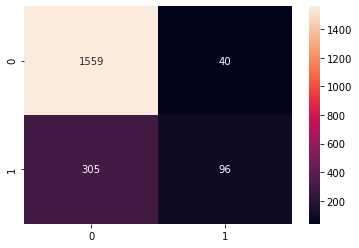

In [19]:
# Making the Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [21]:
# Predicting a single new observation
"""Predict if the customer with the following informations will leave the bank:
Geography: France
Credit Score: 600
Gender: Male
Age: 40
Tenure: 3
Balance: 60000
Number of Products: 2
Has Credit Card: Yes
Is Active Member: Yes
Estimated Salary: 50000"""
new_prediction = grid_search.predict(sc.transform(np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))
new_prediction = (new_prediction > 0.5)
new_prediction

/home/rajan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[False]])

## Checkpoint

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # load weights
    # model.load_weights("weights.best.hdf5")
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

parameters = {'batch_size': [25],
              'epochs': [5],
              'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs=1)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

grid_search = grid_search.fit(X_train, y_train, callbacks=callbacks_list, verbose=0)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_






Epoch 00001: saving model to weights.best.hdf5

Epoch 00002: saving model to weights.best.hdf5

Epoch 00003: saving model to weights.best.hdf5

Epoch 00004: saving model to weights.best.hdf5

Epoch 00005: saving model to weights.best.hdf5

Epoch 00001: saving model to weights.best.hdf5

Epoch 00002: saving model to weights.best.hdf5

Epoch 00003: saving model to weights.best.hdf5

Epoch 00004: saving model to weights.best.hdf5

Epoch 00005: saving model to weights.best.hdf5

Epoch 00001: saving model to weights.best.hdf5

Epoch 00002: saving model to weights.best.hdf5

Epoch 00003: saving model to weights.best.hdf5

Epoch 00004: saving model to weights.best.hdf5

Epoch 00005: saving model to weights.best.hdf5

Epoch 00001: saving model to weights.best.hdf5

Epoch 00002: saving model to weights.best.hdf5

Epoch 00003: saving model to weights.best.hdf5

Epoch 00004: saving model to weights.best.hdf5

Epoch 00005: saving model to weights.best.hdf5

Epoch 00001: saving model to weights.be

<AxesSubplot:>

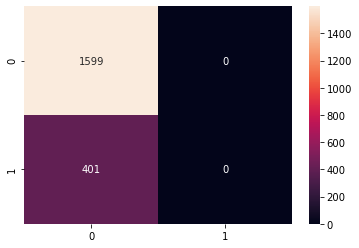

In [31]:
# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = grid_search.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")


In [30]:
# Predicting a single new observation
"""Predict if the customer with the following informations will leave the bank:
Geography: France
Credit Score: 600
Gender: Male
Age: 40
Tenure: 3
Balance: 60000
Number of Products: 2
Has Credit Card: Yes
Is Active Member: Yes
Estimated Salary: 50000"""
new_prediction = grid_search.predict(sc.transform(np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))
new_prediction = (new_prediction > 0.5)
new_prediction


/home/rajan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[False]])